In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# https://huggingface.co/datasets/Mozilla/alt-text-validation
# https://huggingface.co/datasets/Mozilla/flickr30k-transformed-captions-gpt4o?row=0

In [3]:
from datasets import load_dataset
from itertools import islice



/opt/anaconda3/envs/altauthor/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

dataset = load_dataset("Mozilla/alt-text-validation", streaming=True)

input_data = []
for data in islice(dataset["train"], 2):
    # print(data)
    input_data.append(data)


In [5]:
input_data[0]

{'dataset': 'Pexels',
 'image_id': 2034,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=467x700>,
 'alt_text': 'Face of Woman',
 'license': 'public domain',
 'source': 'https://www.pexels.com/@emilianovittoriosi',
 'inclusive_alt_text': '',
 'need_training': 0,
 'verified': 0,
 'rejection_reasons': [],
 'added_by': 'admin',
 'verified_by': '',
 'modified_date': datetime.datetime(2024, 6, 20, 13, 8, 19, 439875),
 'nsfw': 0,
 'golden': 0,
 'gpt_alt_text': 'A person with a thoughtful expression and styled hair.'}

In [6]:
from IPython.display import display, Markdown
def display_image_with_text(data):
    # 마크다운 형식으로 텍스트 표시
    display(Markdown(f"""
    Human Alt Text: {data['alt_text']}  
    GPT Alt Text: {data['gpt_alt_text']}
    """))
    # 이미지 표시
    display(data['image'])


    Human Alt Text: Face of Woman  
    GPT Alt Text: A person with a thoughtful expression and styled hair.
    

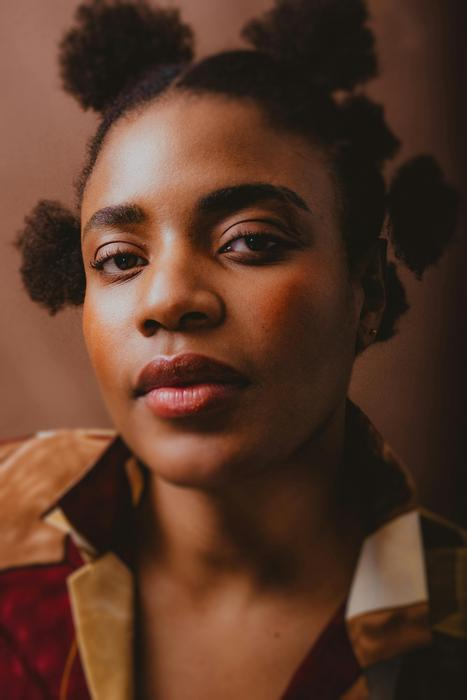

In [7]:
display_image_with_text(input_data[0])

In [8]:
import base64
from io import BytesIO

def encode_image(image_obj):
    if isinstance(image_obj, str):  # 파일 경로인 경우
        with open(image_obj, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
    else:  # 이미지 객체인 경우
        buffered = BytesIO()
        image_obj.save(buffered, format="PNG")  # 객체를 PNG 형식으로 저장
        return base64.b64encode(buffered.getvalue()).decode("utf-8")

In [9]:
encoded_image = encode_image(input_data[0]["image"])
alt_text = input_data[0]["alt_text"]

In [13]:
import aisuite as ai
import logging

logging.basicConfig(level=logging.DEBUG)


client = ai.Client()

models = ["openai:gpt-4o"]
system_prompt = """
You are a helpful assistant tasked with verifying the relevance and accuracy of alt-text for images. When provided with an image and its corresponding alt-text, your goal is to determine:
	1.	Whether the alt-text accurately describes the content of the image.
	2.	Whether the alt-text is clear, concise, and provides meaningful context for visually impaired users.
	3.	If improvements are needed, suggest a revised alt-text that better aligns with the image.

Your evaluation should be structured as follows:
	•	Accuracy: Is the description factually correct and relevant to the image?
	•	Clarity: Is the description easy to understand and free of ambiguity?
	•	Completeness: Does the alt-text include key details necessary for understanding the image without being overly verbose?
	•	Suggestions for Improvement (if applicable): Provide an improved version of the alt-text.

Focus on providing actionable and constructive feedback. Avoid including unnecessary details or unrelated commentary.
"""

user_prompt = f"""
I will provide an image and its corresponding alt-text. Please verify if the alt-text is appropriate for the image based on the following criteria:
	1.	Accuracy: Does the alt-text correctly describe the image?
	2.	Clarity: Is the alt-text easy to understand?
	3.	Completeness: Does the alt-text include the necessary details without being too verbose?

If the alt-text is insufficient or incorrect, suggest an improved version.

INPUT:
	- {alt_text}
OUTPUT:
	- revised alt-text
"""

messages = [
    {
        "role": "system", 
        "content": system_prompt},
	{
        "role": "user", 
        "content": [
            {
                "type": "text",
                "text": user_prompt,
			},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{encoded_image}"
				},
			},
		]
	}
]


response = client.chat.completions.create(
    model=models[0],
    messages=messages,
    temperature=0.0,
    timeout=30,
)

print(response.choices[0].message.content)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


**Accuracy:** The alt-text "Face of Woman" is accurate but lacks detail.

**Clarity:** The description is clear but very minimal.

**Completeness:** The alt-text is too brief and does not provide enough context or detail about the image.

**Suggestions for Improvement:** 
"Close-up of a woman with natural hair styled in multiple puffs, wearing a patterned shirt, looking directly at the camera with a neutral expression."
